In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!unzip "/content/drive/MyDrive/Colab Notebooks/raw.zip" -d "/content/raw"


!ls "/content/raw"



Archive:  /content/drive/MyDrive/Colab Notebooks/raw.zip
replace /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_1.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_1_1.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_10.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_10_1.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_100.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_100_1.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_101.mp4  
  inflating: /content/raw/Shop DataSet/non shop lifters/shop_lifter_n_101_1.mp4  
  inflating: /content/raw/Shop 

In [ ]:
!pip install opencv-python


In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Colab-compatible paths
RAW_DATA_DIR = "/content/raw"
SHOPLIFTING_DIR = "/content/raw/Shop DataSet/shop lifters"
NON_SHOPLIFTING_DIR = "/content/raw/Shop DataSet/non shop lifters"


# Display available data
print(f"Shoplifting videos: {len(os.listdir(SHOPLIFTING_DIR))} videos")
print(f"Non-shoplifting videos: {len(os.listdir(NON_SHOPLIFTING_DIR))} videos")



Shoplifting videos: 324 videos
Non-shoplifting videos: 531 videos


In [ ]:
def get_video_info(video_path):
    """Extract basic information from a video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None

    # Get video properties
    info = {
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "fps": cap.get(cv2.CAP_PROP_FPS),
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "format": os.path.splitext(video_path)[1],
        "path": video_path
    }

    info["duration"] = info["frame_count"] / info["fps"]
    cap.release()
    return info

# Analyze videos in both categories
shoplifting_videos = []
for video_file in os.listdir(SHOPLIFTING_DIR):
    video_path = os.path.join(SHOPLIFTING_DIR, video_file)
    info = get_video_info(video_path)
    if info:
        info['label'] = 'shoplifting'
        shoplifting_videos.append(info)

non_shoplifting_videos = []
for video_file in os.listdir(NON_SHOPLIFTING_DIR):
    video_path = os.path.join(NON_SHOPLIFTING_DIR, video_file)
    info = get_video_info(video_path)
    if info:
        info['label'] = 'normal'
        non_shoplifting_videos.append(info)

# Combine into one dataset
all_videos = pd.DataFrame(shoplifting_videos + non_shoplifting_videos)
print(f"Total videos analyzed: {len(all_videos)}")
all_videos.head()

Total videos analyzed: 855


,width,height,fps,frame_count,format,path,duration,label
0,704,576,25.00,250,.mp4,/content/raw/Shop DataSet/shop lifters/videyyy...,10.0,shoplifting
1,704,576,25.00,525,.mp4,/content/raw/Shop DataSet/shop lifters/shop_li...,21.0,shoplifting
2,704,576,24.75,297,.mp4,/content/raw/Shop DataSet/shop lifters/shop_li...,12.0,shoplifting
3,704,576,25.00,225,.mp4,/content/raw/Shop DataSet/shop lifters/videyyy...,9.0,shoplifting
4,704,576,25.00,375,.mp4,/content/raw/Shop DataSet/shop lifters/videppp...,15.0,shoplifting


Sample shoplifting video frames:


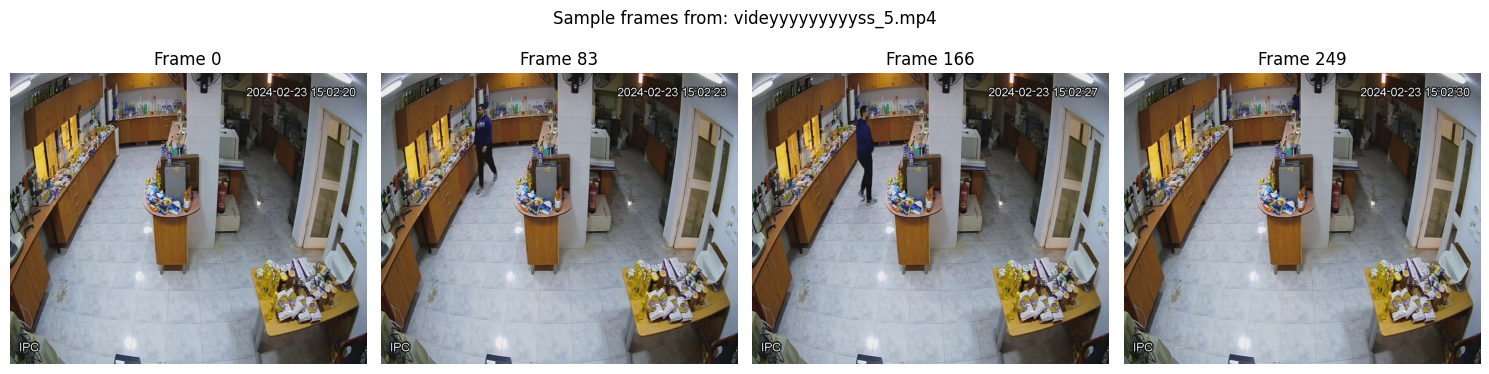

Sample non-shoplifting video frames:


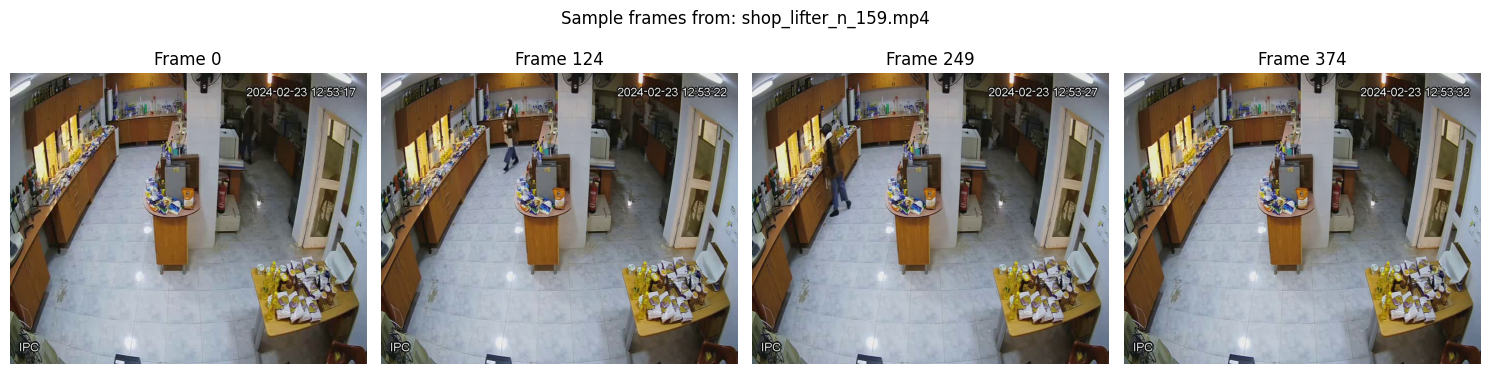

In [ ]:
def display_video_frames(video_path, num_frames=4):
    """Display sample frames from a video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    fig, axes = plt.subplots(1, num_frames, figsize=(15, 4))
    for i, frame_idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

    cap.release()
    plt.suptitle(f"Sample frames from: {os.path.basename(video_path)}")
    plt.tight_layout()
    plt.show()

# Display sample frames from a shoplifting video
if len(shoplifting_videos) > 0:
    print("Sample shoplifting video frames:")
    display_video_frames(shoplifting_videos[0]['path'])

# Display sample frames from a non-shoplifting video
if len(non_shoplifting_videos) > 0:
    print("Sample non-shoplifting video frames:")
    display_video_frames(non_shoplifting_videos[0]['path'])

In [ ]:
import os
import cv2
import pandas as pd
from pathlib import Path
import logging
import random

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

def preprocess_videos(raw_data_dir, output_dir, frame_interval=5, train_ratio=0.7, val_ratio=0.15):
    """
    Extract frames from short videos and organize into train/val/test splits

    Args:
        raw_data_dir: Directory containing shoplifting/non-shoplifting videos in subdirectories
        output_dir: Where to save the extracted frames
        frame_interval: Extract one frame every N frames (lower value for short videos)
        train_ratio: Percentage of videos to use for training
        val_ratio: Percentage of videos to use for validation (remaining goes to test)
    """
    # Create output directories
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)  # Ensure the parent directories are created

    # Create train, val, test directories with label subdirectories
    for split in ['train', 'val', 'test']:
        (output_path / split / 'shoplifting').mkdir(parents=True, exist_ok=True)
        (output_path / split / 'non_shoplifting').mkdir(parents=True, exist_ok=True)

    # Track all extracted frames for metadata
    all_frames = []

    # Process each class directory
    raw_data_path = Path(raw_data_dir)
    for class_dir in ['shop lifters', 'non shop lifters']:
        class_path = raw_data_path / class_dir
        label = 'shoplifting' if class_dir == 'shop lifters' else 'non_shoplifting'

        # Get all video files in this class directory
        video_files = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        random.shuffle(video_files)  # Shuffle to ensure random distribution across splits

        # Calculate split indices
        train_idx = int(len(video_files) * train_ratio)
        val_idx = train_idx + int(len(video_files) * val_ratio)

        # Assign videos to splits
        train_videos = video_files[:train_idx]
        val_videos = video_files[train_idx:val_idx]
        test_videos = video_files[val_idx:]

        # Process videos for each split
        for split, videos in [('train', train_videos), ('val', val_videos), ('test', test_videos)]:
            logger.info(f"Processing {len(videos)} {label} videos for {split} split")

            for video_name in videos:
                video_path = class_path / video_name
                logger.info(f"Extracting frames from {video_path}")

                # Open video
                cap = cv2.VideoCapture(str(video_path))
                if not cap.isOpened():
                    logger.error(f"Could not open video: {video_path}")
                    continue

                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                logger.info(f"Video details: {video_name}, FPS: {fps}, Total frames: {total_frames}")

                # For very short videos, ensure we extract at least 5-10 frames
                actual_interval = min(frame_interval, max(1, total_frames // 8))

                # Extract frames
                frame_count = 0
                saved_count = 0

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Save one frame every actual_interval frames
                    if frame_count % actual_interval == 0:
                        frame_filename = f"{video_name.split('.')[0]}_frame{saved_count:04d}.jpg"
                        frame_path = output_path / split / label / frame_filename

                        cv2.imwrite(str(frame_path), frame)

                        # Add to metadata
                        all_frames.append({
                            'frame_path': str(frame_path),
                            'video_name': video_name,
                            'label': 1 if label == 'shoplifting' else 0,
                            'split': split,
                            'frame_number': frame_count,
                            'timestamp': frame_count / fps if fps > 0 else 0
                        })

                        saved_count += 1

                    frame_count += 1

                cap.release()
                logger.info(f"Extracted {saved_count} frames from {video_name} ({total_frames} total frames)")

    # Save metadata
    frames_df = pd.DataFrame(all_frames)
    frames_df.to_csv(output_path / "frames_metadata.csv", index=False)

    # Print summary
    logger.info(f"Preprocessing complete. Total frames: {len(frames_df)}")
    for split in ['train', 'val', 'test']:
        split_df = frames_df[frames_df['split'] == split]
        shoplifting_count = sum(split_df['label'] == 1)
        non_shoplifting_count = sum(split_df['label'] == 0)
        logger.info(f"{split}: {len(split_df)} frames ({shoplifting_count} shoplifting, {non_shoplifting_count} non-shoplifting)")

if __name__ == "__main__":
    # Usage example
    preprocess_videos(
        raw_data_dir="/content/raw/Shop DataSet",
        output_dir="data/processed",
    )


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoImageProcessor, AutoModelForImageClassification

class ShopliftingDataset(Dataset):
    def __init__(self, metadata_csv, base_dir="", transform=None):
        """
        Args:
            metadata_csv: Path to the CSV file with frame metadata
            base_dir: Base directory to prepend to relative paths in metadata
            transform: Optional transforms to apply to images
        """
        self.metadata = pd.read_csv(metadata_csv)
        # Filter by split if needed (using parameter or instance var)
        self.base_dir = base_dir
        self.transform = transform

        # Get absolute paths for images
        if self.base_dir:
            self.metadata['absolute_path'] = self.metadata['frame_path'].apply(
                lambda x: os.path.join(base_dir, x) if not os.path.isabs(x) else x
            )
        else:
            self.metadata['absolute_path'] = self.metadata['frame_path']

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['absolute_path']
        label = self.metadata.iloc[idx]['label']

        # Load and transform image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    """Train the model and return training history"""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            all_preds = []
            all_labels = []

            # Iterate over data
            pbar = tqdm(dataloaders[phase])
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # For transformers model
                    if hasattr(outputs, 'logits'):
                        outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar
                pbar.set_description(f"{phase} loss: {loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            # If we are in validation phase, also calculate other metrics
            if phase == 'val':
                precision = precision_score(all_labels, all_preds, average='weighted')
                recall = recall_score(all_labels, all_preds, average='weighted')
                f1 = f1_score(all_labels, all_preds, average='weighted')
                print(f'Val Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        print()

    return model, history

def evaluate_model(model, dataloader, device):
    """Evaluate model on test set"""
    model.eval()   # Set model to evaluate mode

    all_preds = []
    all_labels = []

    # No gradient calculation needed
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels
    }

def main():
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set up data transforms - MobileNet expects 224x224 images
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # Create datasets
    base_dir = "data"  # Adjust this to your project structure
    metadata_file = os.path.join(base_dir, "processed/frames_metadata.csv")

    full_dataset = pd.read_csv(metadata_file)

    # Create datasets for each split
    datasets = {
        split: ShopliftingDataset(
            metadata_csv=metadata_file,
            base_dir="",  # Use absolute paths from metadata
            transform=data_transforms[split]
        ) for split in ['train', 'val', 'test']
    }

    # Filter datasets by split
    for split in ['train', 'val', 'test']:
        split_indices = full_dataset[full_dataset['split'] == split].index.tolist()
        datasets[split].metadata = datasets[split].metadata.iloc[split_indices]

    # Create dataloaders
    batch_size = 64  # Can use larger batch size with MobileNet
    dataloaders = {
        split: DataLoader(
            datasets[split],
            batch_size=batch_size,
            shuffle=(split == 'train'),
            num_workers=4
        ) for split in ['train', 'val', 'test']
    }

    # Load MobileNetV2 model from HuggingFace
    model_name = "google/mobilenet_v2_1.0_224"  # Fast and efficient model

    print(f"Loading model: {model_name}")
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification: shoplifting vs non-shoplifting
        ignore_mismatched_sizes=True  # Important when changing number of classes
    )

    # Move model to the right device
    model = model.to(device)

    # Setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Slightly higher learning rate for faster training

    # Add a learning rate scheduler for better convergence
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

    # Train model
    print("Starting training...")
    model, history = train_model(
        model,
        dataloaders,
        criterion,
        optimizer,
        device,
        num_epochs=10  # More epochs since MobileNet trains faster
    )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = evaluate_model(model, dataloaders['test'], device)

    # Save model
    model_save_path = os.path.join(base_dir, "models/shoplifting_detector_mobilenet.pth")
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Add a simple function to make predictions on a single video
    def predict_on_video(video_path, output_path=None, frame_interval=5):
        """Process a video and make shoplifting predictions on individual frames"""
        cap = cv2.VideoCapture(video_path)

        # Prepare model for inference
        model.eval()

        predictions = []
        frame_count = 0

        # Setup video writer if output path is provided
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        with torch.no_grad():
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Process every nth frame
                if frame_count % frame_interval == 0:
                    # Preprocess frame
                    pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    img_tensor = data_transforms['test'](pil_frame).unsqueeze(0).to(device)

                    # Get prediction
                    outputs = model(img_tensor)
                    if hasattr(outputs, 'logits'):
                        outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    pred_label = preds.item()
                    predictions.append(pred_label)

                    # Add prediction to frame if writing video
                    if output_path:
                        label_text = "SHOPLIFTING" if pred_label == 1 else "NORMAL"
                        color = (0, 0, 255) if pred_label == 1 else (0, 255, 0)  # Red for shoplifting, Green for normal
                        cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                        out.write(frame)

                frame_count += 1

        cap.release()
        if output_path:
            out.release()

        # Calculate overall prediction (majority vote)
        if predictions:
            shoplifting_prob = sum(predictions) / len(predictions)
            overall_pred = "SHOPLIFTING" if shoplifting_prob > 0.5 else "NORMAL"
            return overall_pred, shoplifting_prob
        else:
            return "No frames processed", 0.0

    print("\nModel is ready for inference. You can use the predict_on_video function to analyze videos.")

    return model, history, test_results

if __name__ == "__main__":
    main()

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading model: google/mobilenet_v2_1.0_224


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...
Epoch 1/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0490: 100%|██████████| 621/621 [06:42<00:00,  1.54it/s]


train Loss: 0.0419 Acc: 0.9838


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:01<00:00,  2.13it/s]


val Loss: 0.0090 Acc: 0.9958
Val Precision: 0.9958, Recall: 0.9958, F1: 0.9958

Epoch 2/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0058: 100%|██████████| 621/621 [06:19<00:00,  1.63it/s]


train Loss: 0.0096 Acc: 0.9969


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:01<00:00,  2.10it/s]


val Loss: 0.0029 Acc: 0.9988
Val Precision: 0.9988, Recall: 0.9988, F1: 0.9988

Epoch 3/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0004: 100%|██████████| 621/621 [06:50<00:00,  1.51it/s]


train Loss: 0.0069 Acc: 0.9980


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:10<00:00,  1.84it/s]


val Loss: 0.0075 Acc: 0.9974
Val Precision: 0.9974, Recall: 0.9974, F1: 0.9974

Epoch 4/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0000: 100%|██████████| 621/621 [06:56<00:00,  1.49it/s]


train Loss: 0.0072 Acc: 0.9977


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:09<00:00,  1.87it/s]


val Loss: 0.0017 Acc: 0.9990
Val Precision: 0.9990, Recall: 0.9990, F1: 0.9990

Epoch 5/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0001: 100%|██████████| 621/621 [06:47<00:00,  1.52it/s]


train Loss: 0.0057 Acc: 0.9982


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:02<00:00,  2.08it/s]


val Loss: 0.0121 Acc: 0.9971
Val Precision: 0.9971, Recall: 0.9971, F1: 0.9971

Epoch 6/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0043: 100%|██████████| 621/621 [06:19<00:00,  1.64it/s]


train Loss: 0.0040 Acc: 0.9988


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:09<00:00,  1.88it/s]


val Loss: 0.0007 Acc: 0.9999
Val Precision: 0.9999, Recall: 0.9999, F1: 0.9999

Epoch 7/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0000: 100%|██████████| 621/621 [06:48<00:00,  1.52it/s]


train Loss: 0.0021 Acc: 0.9994


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:10<00:00,  1.85it/s]


val Loss: 0.0001 Acc: 1.0000
Val Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Epoch 8/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0030: 100%|██████████| 621/621 [06:50<00:00,  1.51it/s]


train Loss: 0.0047 Acc: 0.9984


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:08<00:00,  1.90it/s]


val Loss: 0.0038 Acc: 0.9994
Val Precision: 0.9994, Recall: 0.9994, F1: 0.9994

Epoch 9/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0002: 100%|██████████| 621/621 [06:50<00:00,  1.51it/s]


train Loss: 0.0070 Acc: 0.9979


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:09<00:00,  1.87it/s]


val Loss: 0.0013 Acc: 0.9998
Val Precision: 0.9998, Recall: 0.9998, F1: 0.9998

Epoch 10/10
----------


  0%|          | 0/621 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train loss: 0.0001: 100%|██████████| 621/621 [06:51<00:00,  1.51it/s]


train Loss: 0.0033 Acc: 0.9988


  0%|          | 0/130 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val loss: 0.0000: 100%|██████████| 130/130 [01:08<00:00,  1.90it/s]


val Loss: 0.0010 Acc: 0.9995
Val Precision: 0.9995, Recall: 0.9995, F1: 0.9995


Evaluating on test set...


  0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 137/137 [01:13<00:00,  1.87it/s]


Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000
Model saved to data/models/shoplifting_detector_mobilenet.pth

Model is ready for inference. You can use the predict_on_video function to analyze videos.


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import AutoModelForImageClassification
import os

def predict_on_single_image(model_path, image_path, device="cpu"):
    """
    Test the model on a single image

    Args:
        model_path: Path to the trained model
        image_path: Path to the image to test
        device: Device to run inference on

    Returns:
        tuple: (prediction label, confidence score)
    """
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None, 0.0

    # Load model
    model = AutoModelForImageClassification.from_pretrained(
        "google/mobilenet_v2_1.0_224",
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    # Load saved weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Prepare image transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        # Get probabilities using softmax
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, preds = torch.max(probs, 1)

    pred_label = "SHOPLIFTING" if preds.item() == 1 else "NORMAL"
    conf_score = confidence.item()

    return pred_label, conf_score

# Test the model on your specific image
model_path = "data/models/shoplifting_detector_mobilenet.pth"  # Update this to your model path
image_path = "/content/data/processed/test/shoplifting/shop_lifter_104_frame0003.jpg"

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Make prediction
prediction, confidence = predict_on_single_image(model_path, image_path, device)
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.4f}")

Using device: cuda:0


Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: SHOPLIFTING
Confidence: 1.0000


In [ ]:
!pip install djangorestframework opencv-python numpy

In [ ]:
!mkdir -p shoplifting_api/detector/migrations
!mkdir -p shoplifting_api/shoplifting_api
!mkdir -p shoplifting_api/model
!mkdir -p shoplifting_api/media/images
!touch shoplifting_api/__init__.py
!touch shoplifting_api/shoplifting_api/__init__.py
!touch shoplifting_api/detector/__init__.py
!touch shoplifting_api/detector/migrations/__init__.py



In [ ]:
!pip show django djangorestframework torch torchvision

Name: Django
Version: 5.2
Summary: A high-level Python web framework that encourages rapid development and clean, pragmatic design.
Home-page: https://www.djangoproject.com/
Author: 
Author-email: Django Software Foundation <foundation@djangoproject.com>
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: asgiref, sqlparse
Required-by: djangorestframework
---
Name: djangorestframework
Version: 3.16.0
Summary: Web APIs for Django, made easy.
Home-page: https://www.django-rest-framework.org/
Author: Tom Christie
Author-email: tom@tomchristie.com
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: django
Required-by: 
---
Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx,

In [ ]:
%%writefile shoplifting_api/shoplifting_api/settings.py
import os
from pathlib import Path

BASE_DIR = Path(__file__).resolve().parent.parent

SECRET_KEY = 'django-insecure-your-secret-key-here'

DEBUG = True

ALLOWED_HOSTS = ['*']

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'rest_framework',
    'detector',
]

MIDDLEWARE = [
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.common.CommonMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

ROOT_URLCONF = 'shoplifting_api.urls'

TEMPLATES = [
    {
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [],
        'APP_DIRS': True,
        'OPTIONS': {
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        },
    },
]

WSGI_APPLICATION = 'shoplifting_api.wsgi.application'

DATABASES = {
    'default': {
        'ENGINE': 'django.db.backends.sqlite3',
        'NAME': BASE_DIR / 'db.sqlite3',
    }
}

LANGUAGE_CODE = 'en-us'
TIME_ZONE = 'UTC'
USE_I18N = True
USE_TZ = True

STATIC_URL = 'static/'
MEDIA_URL = '/media/'
MEDIA_ROOT = os.path.join(BASE_DIR, 'media')

DEFAULT_AUTO_FIELD = 'django.db.models.BigAutoField'

MODEL_PATH = os.path.join(BASE_DIR, 'model', 'shoplifting_detector_mobilenet.pth')

Writing shoplifting_api/shoplifting_api/settings.py
